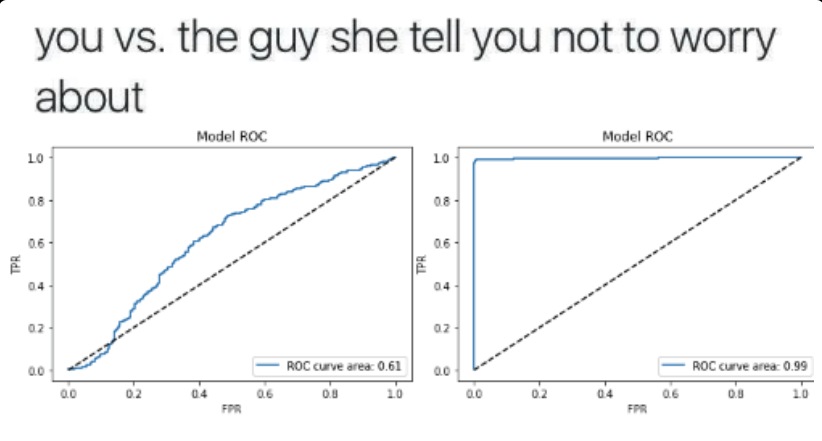

# Loss functions

In [36]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import missing_values_module as mvm
import pipeline_demo_module as pipe
from feature_engine.imputation import RandomSampleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from feature_engine import imputation
import sklearn 
from sklearn import metrics 
#!pip install hmeasure
import hmeasure as h
from functools import partial

from importlib import reload
mvm = reload(mvm)
from importlib import reload
pipe = reload(pipe)

## Simple model for benchmarking

In [5]:
df = mvm.create_test_df(imbalanced = 0.1, long = 10)
train, test, y_train, y_test = train_test_split(df.drop("target", axis = 1), df["target"])

In [6]:
PCA_module = pipe.PCA_adj(
    n_components = 4,    # сколько оставить компонентов; по дефолту - все
    whiten = False,      # отключаем whitening - декорреляцию фичей
    svd_solver = "full", # детали SVD преобразования, за подробностями см. доки
)

StScal = StandardScaler()

Basic = LogisticRegression(penalty="none", max_iter=100, n_jobs = 7)

WoE_module = pipe.WoEEncoder_adj(variables = ["xcat"])

RSImputer = RandomSampleImputer()

RUS_module  = RandomUnderSampler(random_state = 42)

ROS_module    = RandomOverSampler(random_state = 42)



In [7]:
modules = OrderedDict([
    ('WoE',        WoE_module),
    ('ROS' ,       ROS_module),
    ("RUS" ,       RUS_module),
    ('PCA',        PCA_module),
    ('StScal',     StScal),
    ("Basic" ,     Basic),
    ("RSImputer" , RSImputer)])

pipe_params = OrderedDict([
    # 'missing_vals', 
    ('imputer' ,      pipe.hp.choice('imputer', ["RSImputer"])),
    ('cat_encoding',  pipe.hp.choice('cat_encoding', ['WoE'])),
    ('imbalance',     pipe.hp.choice('imbalance',    ['skip', 'RUS', 'ROS'])),
    ('feat_eng',      pipe.hp.choice('feat_eng',     ['skip', 'PCA'])), 
    ("Basic" , "Basic")
])

pipe_level = {
    "RSImputer" : "NaNsFirst",
    'WoE':        "EncodeSecond",
    'ROS' :       "NotImportant",
    "RUS" :       "NotImportant",
    'PCA':        "NotImportant",
    'StScal':     "NotImportant",
    "skip" : "NotImportant",
    "Basic" :     "ModelLast"
}
pipe_endings = OrderedDict([
    ('Basic',         'Basic')
])

# set_params = OrderedDict([
#     ('feateng__PCA__n_components' , pipe.hp.choice("PCA__n_components", [1,2,7,10]))])

set_params = OrderedDict([
    ('feateng__PCA__n_components' , pipe.hp.choice("PCA__n_components", [2,10]))])

pipe_para = dict()
pipe_para['pipe_params']    = pipe_params
pipe_para['pipe_endings']   = pipe_endings
pipe_para['set_params']     = set_params
pipe_para['loss_func']      = lambda y, pred: -sklearn.metrics.roc_auc_score(y, pred)

In [47]:
hpoptimizer = pipe.PipeHPOpt_unmodified(train, y_train, modules=modules, order = pipe_level, mode='kfold', n_folds = 5, seed=42)
lgb_opt, trials = hpoptimizer.process(space=pipe_para, trials=pipe.Trials(), algo=pipe.tpe.suggest, max_evals=1000)

100%|███████████████████████████████████████████| 1000/1000 [09:48<00:00,  1.70trial/s, best loss: -0.5286007205829285]


Несколько вспомогательных функций

In [70]:
class confusion_metrics_container():
    def __init__(self, true, pred):
        if type(true) != type(np.array([1,1])):
            true = np.array(true)
        if type(pred) != type(np.array([1,1])):
            pred = np.array(pred)
        confusion_matrix = metrics.confusion_matrix(y_true = np.array(true), y_pred = np.array(pred))
        self.num = len(true)
        self.TP = confusion_matrix[1,1]
        self.TN = confusion_matrix[0,0]
        self.FP = confusion_matrix[0,1]
        self.FN = confusion_matrix[1,0]
    
def TPR(y_true, y_pred):
    confusion = confusion_metrics_container(y_true, y_pred)
    return confusion.TP/(confusion.TP+confusion.FN)

def TNR(y_true, y_pred):
    confusion = confusion_metrics_container(y_true, y_pred)
    return confusion.TN/(confusion.TN + confusion.FP)

def FPR(y_true, y_pred):
    confusion = confusion_metrics_container(y_true, y_pred)
    return confusion.FP/(confusion.TN + confusion.FP)

def FNR(y_true, y_pred):
    confusion = confusion_metrics_container(y_true, y_pred)
    return confusion.FN/(confusion.TP + confusion.FN)

def precision(y_true, y_pred):
    confusion = confusion_metrics_container(y_true, y_pred)
    return confusion.TP/(confusion.TP + confusion.FP)

def NPV(y_true, y_pred):
    confusion = confusion_metrics_container(y_true, y_pred)
    return confusion.TN/(confusion.TN + confusion.FN)

def accuracy(y_true, y_pred):
    confusion = confusion_metrics_container(y_true, y_pred)
    return (confusion.TP + confusion.TN)/(confusion.TP + confusion.TN + confusion.FP + confusion.FN)

def f_measure_basic(y_true, y_pred, beta = 1): #if beta = 1, equal weight to precision and reecall; 
                     #the greater the beta - the more weight to recall
    confusion = confusion_metrics_container(y_true, y_pred)
    return (((1 + beta)**2) * confusion.TP * precision(y_true, y_pred))/((beta**2) * precision(y_true, y_pred) * confusion.TP)

def f_measure(beta = 1):
    return lambda y_true, y_pred : f_measure_basic(y_true, y_pred, beta = beta)

def geometric_mean(y_true, y_pred):
    confusion = confusion_metrics_container(y_true, y_pred)
    return (confusion.TP * confusion.TN) ** (0.5)

# def geometric_mean_positive(y_true, y_pred): #gives more weight to positive class
#     confusion = confusion_metrics_container(y_true, y_pred)
#     return (confusion.TP * confusion.precision) ** (0.5)

def dominance(y_true, y_pred): #+1 if perfect accuracy for positive class, but no accuracy for negative;
                     #-1 if for perfect negative and no positive
    confusion = confusion_metrics_container(y_true, y_pred)
    return TPR(y_true, y_pred) - TNR(y_true, y_pred)

def dominance_pipeline_basic(y_true, y_pred,alpha = 0): #make dominance appropriate for the pipeline
                     #alpha is the desired value of dominance
    confusion = confusion_metrics_container(y_true, y_pred)
    return np.abs(dominance(y_true, y_pred) - alpha)

def dominance_pipeline(alpha = 0):
    return lambda y_true, y_pred : dominance_pipeline_basic(y_true, y_pred, alpha = alpha)

def IBA_basic(y_true, y_pred,alpha = 1, M = accuracy): #alpha gives more importance to dominance
                                             #M is a user-defined measure of accuracy
    confusion = confusion_metrics_container(y_true, y_pred)
    return (1 + dominance(y_true, y_pred)) * M(y_true, y_pred)

def IBA(alpha = 1, M = accuracy):
    return lambda y_true, y_pred : IBA_basic(y_true, y_pred, alpha = alpha, M = M)

def CWA_basic(y_true, y_pred,omega = 0.5): #omega from [0,1]; larger - more importance to positive class
    confusion = confusion_metrics_container(y_true, y_pred)
    return omega * TPR(y_true, y_pred) + (1 - omega) * TNR(y_true, y_pred)

def CWA(omega = 0.5):
    return lambda y_true, y_pred : CWA_basic(y_true, y_pred, omega = omega)


def rocauc(y_true, y_pred):
    return -sklearn.metrics.roc_auc_score(y_true, y_pred)

def KK(y_true, y_pred):
    if type(y_true) != type(np.array([1,1])):
        y_true = np.array(y_true)
    if type(pred) != type(np.array([1,1])):
        y_pred = np.array(y_pred)
    p0 = metrics.accuracy_score(y_true, y_pred)
    m0, m1 = y_true.mean(), y_pred.mean()
    pe = m0 * m1 + (1 - m0) * (1 - m1)
    return (p0 - pe) / (1 - pe)

def matthews_cor(y_true, y_pred):
    if type(y_true) != type(np.array([1,1])):
        y_true = np.array(y_true)
    if type(pred) != type(np.array([1,1])):
        y_pred = np.array(y_pred)
    m = metrics.confusion_matrix(y_true, y_pred)
    sums = np.r_[m.sum(0), m.sum(1)]
    if 0 in sums:
        return 0
    else:
        return np.linalg.det(m) / np.sqrt(sums.prod())
    
def h_measure_basic(y_true, y_pred, severity): #severity is relation of cost of misclassifying class 0
                                         #to cost of misclassifying class 1
    return h.h_score(np.array(y_true), np.array(y_pred), severity)

def h_measure(severity):
    return lambda y_true, y_pred : h_measure_basic(y_true, y_pred, severity = severity)

In [65]:
type(np.array([1,1])) == type(np.array([1,1]))

True

Теперь проверим, что функции вообще работают

In [71]:
true = [1,1,1,0,0,0,1]
pred = [1,0,1,1,0,1,0]

print(TPR(true, pred))
print(TNR(true, pred))
print(FPR(true, pred))
print(FNR(true, pred))
print(precision(true, pred))
print(NPV(true, pred))
print(accuracy(true, pred))
print(f_measure(beta = 0.5)(true, pred))
print(geometric_mean(true, pred))
print(dominance_pipeline(0)(true, pred))
print(IBA()(true, pred))
print(CWA()(true, pred))
print(rocauc(true, pred))
print(KK(true, pred))
print(matthews_cor(true, pred))
print(h_measure(0.5)(true, pred))

0.5
0.3333333333333333
0.6666666666666666
0.5
0.5
0.3333333333333333
0.42857142857142855
9.0
1.4142135623730951
0.16666666666666669
0.5
0.41666666666666663
-0.41666666666666663
-0.16666666666666674
-0.16666666666666666
2.220446049250313e-16


Встроим несколько в сильно облегченный пайплайн:

In [72]:
pipe_para["loss_func"] = h_measure(0.1)
hpoptimizer = pipe.PipeHPOpt_unmodified(train, y_train, modules=modules, order = pipe_level, mode='kfold', n_folds = 2, seed=42)
lgb_opt, trials = hpoptimizer.process(space=pipe_para, trials=pipe.Trials(), algo=pipe.tpe.suggest, max_evals=100)

100%|██████████████████████████████████████████| 100/100 [01:06<00:00,  1.50trial/s, best loss: 2.3291610862230525e-10]


In [75]:
pipe_para["loss_func"] = geometric_mean
hpoptimizer = pipe.PipeHPOpt_unmodified(train, y_train, modules=modules, order = pipe_level, mode='kfold', n_folds = 2, seed=42)
lgb_opt, trials = hpoptimizer.process(space=pipe_para, trials=pipe.Trials(), algo=pipe.tpe.suggest, max_evals=100)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: Classification metrics can't handle a mix of binary and continuous targets



  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]


In [77]:
pipe_para["loss_func"] = dominance_pipeline(0)
hpoptimizer = pipe.PipeHPOpt_unmodified(train, y_train, modules=modules, order = pipe_level, mode='kfold', n_folds = 2, seed=42)
lgb_opt, trials = hpoptimizer.process(space=pipe_para, trials=pipe.Trials(), algo=pipe.tpe.suggest, max_evals=100)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: Classification metrics can't handle a mix of binary and continuous targets



  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]


In [78]:
pipe_para["loss_func"] = KK
hpoptimizer = pipe.PipeHPOpt_unmodified(train, y_train, modules=modules, order = pipe_level, mode='kfold', n_folds = 2, seed=42)
lgb_opt, trials = hpoptimizer.process(space=pipe_para, trials=pipe.Trials(), algo=pipe.tpe.suggest, max_evals=100)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: Classification metrics can't handle a mix of binary and continuous targets



  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]
